## Edinburgh CCTV CNN Autoencoder (2D Latent Space)
 
Trains a convolutional autoencoder on the pixel data from the
trajectories CSV generated in the first notebook.

- Input: CSV with pixel columns (1x1, 1x2, ..., WxH or *_r/g/b)
- Output: trained CNN autoencoder with 2D latent space
- Config: all architecture and training hyperparameters are read from a YAML file


In [1]:
# # Optional: install dependencies in a fresh environment
# # Uncomment as needed.
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install pyyaml pandas numpy matplotlib scikit-learn


In [2]:
# %%
import os
import re
import glob
import tarfile
import math
from typing import List, Optional, Tuple, Dict, Any

from PIL import Image
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Filename pattern for Edinburgh frames (day_*.tar contents)
FILENAME_RE = re.compile(
    r"inspacecam163_(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})_(\d{2})\.jpg$"
)

# Make matplotlib a bit nicer
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

print("PyTorch version:", torch.__version__)


PyTorch version: 2.5.1+cu121


## 1. Load YAML configuration


In [3]:
# %%
# Path to the YAML configuration file
# Adjust as needed
CONFIG_PATH = "configs/ae_cnn_example.yaml"

if not os.path.exists(CONFIG_PATH):
    os.makedirs(os.path.dirname(CONFIG_PATH), exist_ok=True)
    example_cfg = """
seed: 0

data:
  # Folder containing day_*.tar files from the Edinburgh office dataset
  folder: "."
  grayscale: true              # true = convert to 1 channel, false = RGB (3 channels)
  use_all_times: false         # if true, ignore start_time/end_time
  start_time: "15:00:00"
  end_time: "15:59:59"
  frame_step: 10               # keep every N-th frame per day (after time filtering & sorting)
  max_samples: null            # null = use all selected frames, int = random subset
  train_fraction: 0.9          # fraction of samples used for training, rest for validation
  normalize: true              # divide pixel values by 255.0

model:
  in_channels: 1               # 1 for grayscale, 3 for RGB
  img_width: 128
  img_height: 72
  conv_channels: [32, 64, 128] # encoder conv channels per stage
  kernel_size: 3
  latent_dim: 2
  dropout: 0.1

training:
  num_epochs: 50
  batch_size: 256
  optimizer: adam              # "adam" or "sgd"
  learning_rate: 1.0e-3
  weight_decay: 1.0e-5

device:
  type: "auto"                 # "auto", "cuda", or "cpu"

logging:
  output_dir: "autoencoder_runs"
  run_name: "cnn_ae_v1"
  num_recon_examples: 8
"""
    with open(CONFIG_PATH, "w", encoding="utf-8") as f:
        f.write(example_cfg.strip() + "\n")
    print(f"Wrote example config to {CONFIG_PATH}")

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config: Dict[str, Any] = yaml.safe_load(f)

print("Loaded config from:", CONFIG_PATH)
config


Loaded config from: configs/ae_cnn_example.yaml


{'seed': 0,
 'data': {'folder': '.',
  'grayscale': True,
  'use_all_times': True,
  'start_time': '00:00:00',
  'end_time': '23:59:59',
  'frame_step': 1,
  'max_samples': None,
  'train_fraction': 0.95,
  'normalize': True,
  'cache_root': 'frame_cache',
  'use_cache': True},
 'model': {'in_channels': 1,
  'img_width': 128,
  'img_height': 72,
  'conv_channels': [32, 64, 128],
  'kernel_size': 3,
  'latent_dim': 2,
  'dropout': 0.1},
 'training': {'num_epochs': 1,
  'batch_size': 1024,
  'optimizer': 'adam',
  'learning_rate': 0.001,
  'weight_decay': 1e-05},
 'device': {'type': 'auto'},
 'logging': {'output_dir': 'autoencoder_runs',
  'run_name': 'cnn_ae_v1',
  'num_recon_examples': 8}}

## 2. Reproducibility helpers and column detection


In [4]:
# %%
def set_global_seed(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(False)


set_global_seed(config.get("seed", 0))


## 3. Index frames directly from day\_*.tar files

In [5]:
# %%
from tqdm.auto import tqdm

def parse_time_from_filename(name: str):
    """Returns (hour, minute, second) or None if the filename does not match."""
    base = os.path.basename(name)
    m = FILENAME_RE.match(base)
    if not m:
        return None
    h = int(m.group(4))
    m_ = int(m.group(5))
    s = int(m.group(6))
    return h, m_, s


def seconds_since_midnight(h: int, m: int, s: int) -> int:
    return h * 3600 + m * 60 + s


def parse_time_string(s: str) -> int:
    """
    Parse HH:MM or HH:MM:SS -> seconds since midnight.
    """
    parts = s.split(":")
    if len(parts) == 2:
        h, m = parts
        s_val = 0
    elif len(parts) == 3:
        h, m, s_val = parts
    else:
        raise ValueError(f"Invalid time format: {s!r}. Expected HH:MM or HH:MM:SS")
    h_i = int(h)
    m_i = int(m)
    s_i = int(s_val)
    if not (0 <= h_i < 24 and 0 <= m_i < 60 and 0 <= s_i < 60):
        raise ValueError(f"Time out of range: {s!r}")
    return seconds_since_midnight(h_i, m_i, s_i)


def time_filter(day_sec: int, start_sec: int, end_sec: int, use_all_times: bool) -> bool:
    if use_all_times:
        return True
    return start_sec <= day_sec <= end_sec


def list_tar_files(folder: str) -> List[str]:
    pattern = os.path.join(folder, "day_*.tar")
    tar_paths = sorted(glob.glob(pattern))
    if not tar_paths:
        raise SystemExit(f"No tar files matching 'day_*.tar' found in {folder}")
    return tar_paths


data_cfg = config["data"]
model_cfg = config["model"]

data_folder = data_cfg["folder"]
grayscale = bool(data_cfg.get("grayscale", True))
use_all_times = bool(data_cfg.get("use_all_times", True))
start_time = data_cfg.get("start_time", "00:00:00")
end_time = data_cfg.get("end_time", "23:59:59")
frame_step = int(data_cfg.get("frame_step", 1))
max_samples = data_cfg.get("max_samples", None)

img_w = int(model_cfg["img_width"])
img_h = int(model_cfg["img_height"])
in_channels_model = int(model_cfg["in_channels"])
in_channels_data = 1 if grayscale else 3
if in_channels_model != in_channels_data:
    raise SystemExit(
        f"model.in_channels={in_channels_model} does not match data.grayscale "
        f"(expected {in_channels_data} channels)."
    )
in_channels = in_channels_model

if frame_step <= 0:
    raise ValueError("data.frame_step must be >= 1")

if use_all_times:
    start_sec = 0
    end_sec = 24 * 3600 - 1
else:
    start_sec = parse_time_string(start_time)
    end_sec = parse_time_string(end_time)
    if end_sec < start_sec:
        raise ValueError("end_time must be >= start_time")

tar_paths = list_tar_files(data_folder)
print(f"Found {len(tar_paths)} tar files in {data_folder}")

frame_records: List[Dict[str, Any]] = []
line_index_by_path: Dict[str, int] = {}
line_counter = 0

# --- tqdm added here ---
for path in tqdm(tar_paths, desc="Scanning tar files"):
    line_id = line_counter
    line_index_by_path[path] = line_id
    line_counter += 1

    with tarfile.open(path, "r") as tar:
        # Wrap the inner loop too
        members = [m for m in tar.getmembers() if m.isfile()]

        frames = []
        for member in tqdm(members, leave=False, desc=f"Reading {os.path.basename(path)}"):
            t = parse_time_from_filename(member.name)
            if t is None:
                continue
            h, m_, s = t
            day_sec = seconds_since_midnight(h, m_, s)
            if not time_filter(day_sec, start_sec, end_sec, use_all_times):
                continue
            time_str = f"{h:02d}:{m_:02d}:{s:02d}"
            frames.append((day_sec, time_str, member.name))

        # Sort in time and apply per-day frame_step
        frames.sort(key=lambda x: x[0])
        frames = frames[::frame_step]

        for step, (day_sec, time_str, member_name) in enumerate(frames):
            frame_records.append(
                {
                    "tar_path": path,
                    "member_name": member_name,
                    "line": line_id,
                    "step": step,
                    "day_sec": day_sec,
                    "time_str": time_str,
                }
            )

if not frame_records:
    raise SystemExit("No frames found in the specified time window.")

print(f"Total selected frames before sampling: {len(frame_records)}")

# --- tqdm for subsampling ---
if max_samples is not None:
    max_samples = int(max_samples)
    if max_samples > 0 and max_samples < len(frame_records):
        rng = np.random.default_rng(config.get("seed", 0))
        idx = rng.choice(len(frame_records), size=max_samples, replace=False)
        idx_sorted = np.sort(idx)
        frame_records = [frame_records[i] for i in tqdm(idx_sorted, desc="Applying max_samples")]
        print(f"Subsampled to {len(frame_records)} frames based on max_samples={max_samples}")

line_col_present = True

print("Distinct trajectories (days):", len(line_index_by_path))
print("Final number of frames:", len(frame_records))
print("Image dimensions:", img_w, "x", img_h, "channels =", in_channels)


Found 12 tar files in .


Scanning tar files:   0%|          | 0/12 [00:00<?, ?it/s]

Reading day_1.tar:   0%|          | 0/10047 [00:00<?, ?it/s]

Reading day_10.tar:   0%|          | 0/16253 [00:00<?, ?it/s]

Reading day_11.tar:   0%|          | 0/29568 [00:00<?, ?it/s]

Reading day_12.tar:   0%|          | 0/22344 [00:00<?, ?it/s]

Reading day_2.tar:   0%|          | 0/6719 [00:00<?, ?it/s]

Reading day_3.tar:   0%|          | 0/27235 [00:00<?, ?it/s]

Reading day_4.tar:   0%|          | 0/13082 [00:00<?, ?it/s]

Reading day_5.tar:   0%|          | 0/21793 [00:00<?, ?it/s]

Reading day_6.tar:   0%|          | 0/12652 [00:00<?, ?it/s]

Reading day_7.tar:   0%|          | 0/31706 [00:00<?, ?it/s]

Reading day_8.tar:   0%|          | 0/29002 [00:00<?, ?it/s]

Reading day_9.tar:   0%|          | 0/16250 [00:00<?, ?it/s]

Total selected frames before sampling: 236651
Distinct trajectories (days): 12
Final number of frames: 236651
Image dimensions: 128 x 72 channels = 1


## 4.2 Build or load cached frame tensor

Decode all selected frames *once* into a tensor of shape (N, C, H, W).
If a cache file exists, load it instead of touching the tar files again.

In [6]:
# %% [markdown]
# ## 4. Build or load uint8 memmapped frame cache
#
# Decode all selected frames *once* into a uint8 memmap of shape (N, C, H, W).
# Subsequent runs use np.load(mmap_mode="r") without touching the tar files.

# %%
from collections import defaultdict
from numpy.lib.format import open_memmap

data_cfg = config["data"]

cache_root = data_cfg.get("cache_root", "frame_cache")
os.makedirs(cache_root, exist_ok=True)

folder = data_cfg["folder"]
folder_name = os.path.basename(os.path.abspath(folder)) or "root"

use_all_times_cfg = bool(data_cfg.get("use_all_times", False))
if use_all_times_cfg:
    tw_str = "all"
else:
    start_time_cfg = data_cfg.get("start_time", "00:00:00")
    end_time_cfg = data_cfg.get("end_time", "23:59:59")
    tw_str = f"{start_time_cfg.replace(':','')}-{end_time_cfg.replace(':','')}"

mode = "gray" if data_cfg.get("grayscale", True) else "rgb"
frame_step_cfg = int(data_cfg.get("frame_step", 1))
seed_value = config.get("seed", 0)

base_data_id = (
    f"{folder_name}_w{img_w}h{img_h}_{mode}_tw{tw_str}_step{frame_step_cfg}_seed{seed_value}"
)
frames_path = os.path.join(cache_root, base_data_id + "_frames_uint8.npy")
lines_path = os.path.join(cache_root, base_data_id + "_lines_int64.npy")

# These will be used by the Dataset in the next cell
frames_np: np.memmap
lines_np: np.ndarray

if (
    os.path.exists(frames_path)
    and os.path.exists(lines_path)
    and data_cfg.get("use_cache", True)
):
    print(f"Loading memmapped frames from {frames_path}")
    frames_np = np.load(frames_path, mmap_mode="r")  # memmap (N, C, H, W), uint8
    lines_np = np.load(lines_path)                   # (N,), int64
    print("Loaded frame memmap:", frames_np.shape, frames_np.dtype)
else:
    print("No uint8 cache found; building from tar files into memmap...")

    N = len(frame_records)
    C = in_channels
    H = img_h
    W = img_w

    # Create a .npy file with a memmapped array of the final shape
    frames_mm = open_memmap(
        frames_path,
        mode="w+",
        dtype=np.uint8,
        shape=(N, C, H, W),
    )
    lines_arr = np.empty((N,), dtype=np.int64)

    # Reuse tar handles to avoid reopening the same tar over and over
    tar_cache_local: Dict[str, tarfile.TarFile] = {}

    try:
        for i, rec in enumerate(tqdm(frame_records, desc="Decoding frames into memmap")):
            tar_path = rec["tar_path"]
            if tar_path not in tar_cache_local:
                tar_cache_local[tar_path] = tarfile.open(tar_path, "r")

            tf = tar_cache_local[tar_path]
            member = tf.getmember(rec["member_name"])
            fileobj = tf.extractfile(member)
            if fileobj is None:
                raise RuntimeError(
                    f"Could not extract {rec['member_name']} from {rec['tar_path']}"
                )

            img = Image.open(fileobj)
            if grayscale:
                img = img.convert("L")
            else:
                img = img.convert("RGB")

            img = img.resize((img_w, img_h), resample=Image.BILINEAR)
            arr = np.array(img, dtype=np.uint8)

            if grayscale:
                # (H, W) -> (1, H, W)
                arr_chw = arr[np.newaxis, :, :]
            else:
                # (H, W, C) -> (C, H, W)
                arr_chw = np.transpose(arr, (2, 0, 1))

            frames_mm[i] = arr_chw
            lines_arr[i] = rec["line"]

        # Flush memmap to disk
        frames_mm.flush()
    finally:
        for tf in tar_cache_local.values():
            tf.close()

    np.save(lines_path, lines_arr)
    print("Saved frame memmap to:", frames_path)
    print("Saved line ids to:", lines_path)

    # Re-open in read-only memmap mode for training
    frames_np = np.load(frames_path, mmap_mode="r")
    lines_np = np.load(lines_path)

print("Memmapped frames ready:", frames_np.shape, frames_np.dtype)
print("Lines array:", lines_np.shape, lines_np.dtype)

line_col_present = True


Loading memmapped frames from frame_cache\edinburgh-office-data_w128h72_gray_twall_step1_seed0_frames_uint8.npy
Loaded frame memmap: (236651, 1, 72, 128) uint8
Memmapped frames ready: (236651, 1, 72, 128) uint8
Lines array: (236651,) int64


## 4. Dataset and DataLoader (uint8 memmap)
Frames live in a uint8 memmap on disk. Each batch is converted to float32
and normalized to [0, 1] by the Dataset.

In [7]:
# %%
class MemmapFrameDataset(Dataset):
    def __init__(
        self,
        frames: np.memmap,
        lines: np.ndarray,
        normalize: bool = True,
        return_line: bool = True,
    ):
        """
        frames: memmap (N, C, H, W), dtype uint8
        lines:  ndarray (N,), dtype int64
        """
        self.frames = frames
        self.lines = lines if return_line else None
        self.normalize = normalize
        self.return_line = return_line

    def __len__(self) -> int:
        return self.frames.shape[0]

    def __getitem__(self, idx: int):
        # frames[idx] is a numpy array of shape (C, H, W), dtype uint8
        frame_uint8 = self.frames[idx]

        img = torch.as_tensor(frame_uint8, dtype=torch.float32)
        if self.normalize:
            img = img / 255.0

        if self.lines is not None:
            line_val = int(self.lines[idx])
            return img, line_val
        return img


normalize_flag = bool(config["data"].get("normalize", True))

full_dataset = MemmapFrameDataset(
    frames=frames_np,
    lines=lines_np,
    normalize=normalize_flag,
    return_line=line_col_present,
)

print("Dataset length:", len(full_dataset))

# Train/validation split
train_fraction = float(config["data"].get("train_fraction", 0.9))
train_fraction = max(0.0, min(1.0, train_fraction))
n_total = len(full_dataset)
n_train = int(round(train_fraction * n_total))
n_val = n_total - n_train

if n_train == 0 or n_val == 0:
    # Degenerate cases: all train or all validation
    train_dataset = full_dataset
    val_dataset: Optional[Dataset] = None
    print("No train/validation split performed.")
else:
    generator = torch.Generator().manual_seed(config.get("seed", 0))
    train_dataset, val_dataset = random_split(
        full_dataset,
        [n_train, n_val],
        generator=generator,
    )
    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

train_cfg = config["training"]
batch_size = int(train_cfg["batch_size"])

# Data is now just reading from memmap; 0 workers is usually fine and avoids
# multiprocessing overhead. You can experiment with >0 if you like.
num_workers = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

val_loader = None
if val_dataset is not None:
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

# Optional quick sanity check
sample_batch = next(iter(train_loader))
if line_col_present:
    sample_imgs, sample_lines = sample_batch
else:
    sample_imgs = sample_batch
print("Sample batch image tensor shape:", sample_imgs.shape)

Dataset length: 236651
Train samples: 224818, Validation samples: 11833


C:\Users\Christian\AppData\Local\Temp\ipykernel_27744\2670227293.py:26: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.as_tensor(frame_uint8, dtype=torch.float32)


Sample batch image tensor shape: torch.Size([1024, 1, 72, 128])


## 5. CNN Autoencoder definition (2D latent space)


In [8]:
# %%
class ConvAutoencoder(nn.Module):
    """
    Convolutional autoencoder with a configurable stack of encoder conv blocks
    and mirrored decoder transposed-conv blocks. Latent space is a vector of size
    `latent_dim` (here typically 2).
    """

    def __init__(
        self,
        in_channels: int,
        img_height: int,
        img_width: int,
        conv_channels: List[int],
        kernel_size: int = 3,
        latent_dim: int = 2,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.img_h = img_height
        self.img_w = img_width
        self.latent_dim = latent_dim

        padding = kernel_size // 2

        # Encoder
        encoder_layers: List[nn.Module] = []
        c_in = in_channels
        for c_out in conv_channels:
            encoder_layers.append(
                nn.Conv2d(
                    c_in,
                    c_out,
                    kernel_size=kernel_size,
                    stride=2,  # downsample by factor 2
                    padding=padding,
                    bias=False,
                )
            )
            encoder_layers.append(nn.BatchNorm2d(c_out))
            encoder_layers.append(nn.ReLU(inplace=True))
            if dropout > 0.0:
                encoder_layers.append(nn.Dropout2d(p=dropout))
            c_in = c_out
        self.encoder_conv = nn.Sequential(*encoder_layers)

        # Determine shape after encoder convs using a dummy pass
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, img_height, img_width)
            enc_out = self.encoder_conv(dummy)
        self.enc_out_shape = enc_out.shape[1:]  # (C, H, W)
        enc_flat_dim = int(enc_out.numel() // enc_out.shape[0])

        # Linear layers for latent code
        self.fc_enc = nn.Linear(enc_flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, enc_flat_dim)

        # Decoder: mirror conv stacks with ConvTranspose2d
        decoder_layers: List[nn.Module] = []
        rev_channels = list(reversed(conv_channels))
        for i, c_in_dec in enumerate(rev_channels):
            if i + 1 < len(rev_channels):
                c_out_dec = rev_channels[i + 1]
                final = False
            else:
                c_out_dec = in_channels
                final = True

            # stride=2, padding=1, output_padding=1 yields exact doubling in size
            decoder_layers.append(
                nn.ConvTranspose2d(
                    c_in_dec,
                    c_out_dec,
                    kernel_size=kernel_size,
                    stride=2,
                    padding=padding,
                    output_padding=1,
                    bias=False,
                )
            )

            if not final:
                decoder_layers.append(nn.BatchNorm2d(c_out_dec))
                decoder_layers.append(nn.ReLU(inplace=True))
            else:
                # Map back to [0,1] for normalized intensities
                decoder_layers.append(nn.Sigmoid())

        self.decoder_conv = nn.Sequential(*decoder_layers)

        # Sanity check: confirm output shape matches input shape
        with torch.no_grad():
            x = torch.zeros(1, in_channels, img_height, img_width)
            recon = self.forward(x)[0]
        if recon.shape != x.shape:
            raise RuntimeError(
                f"Autoencoder output shape {recon.shape} does not match input shape {x.shape}. "
                f"Adjust conv configuration."
            )

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)
        z = self.fc_enc(h)
        return z

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h = self.fc_dec(z)
        h = h.view(z.size(0), *self.enc_out_shape)
        x_recon = self.decoder_conv(h)
        return x_recon

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z


conv_channels = [int(c) for c in model_cfg["conv_channels"]]
kernel_size = int(model_cfg.get("kernel_size", 3))
latent_dim = int(model_cfg.get("latent_dim", 2))
dropout = float(model_cfg.get("dropout", 0.0))

ae_model = ConvAutoencoder(
    in_channels=in_channels,
    img_height=img_h,
    img_width=img_w,
    conv_channels=conv_channels,
    kernel_size=kernel_size,
    latent_dim=latent_dim,
    dropout=dropout,
)

print(ae_model)


ConvAutoencoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (fc_enc): Linear(in_features=18432, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=18432, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3

## 6. Training setup


In [ ]:
# %%
device_cfg = config.get("device", {"type": "auto"})
device_type = device_cfg.get("type", "auto")

if device_type == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
elif device_type == "cpu":
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Training device:", device)

ae_model = ae_model.to(device)

train_cfg = config["training"]
num_epochs = int(train_cfg["num_epochs"])
learning_rate = float(train_cfg["learning_rate"])
weight_decay = float(train_cfg.get("weight_decay", 0.0))
optimizer_name = train_cfg.get("optimizer", "adam").lower()

criterion = nn.MSELoss()

if optimizer_name == "adam":
    optimizer = torch.optim.Adam(
        ae_model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
    )
elif optimizer_name == "sgd":
    optimizer = torch.optim.SGD(
        ae_model.parameters(),
        lr=learning_rate,
        momentum=0.9,
        weight_decay=weight_decay,
    )
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

print("Optimizer:", optimizer_name)
print("Learning rate:", learning_rate)
print("Weight decay:", weight_decay)


Training device: cuda
Optimizer: adam
Learning rate: 0.001
Weight decay: 1e-05


## 7. Training loop


In [ ]:
# %%
from tqdm.auto import tqdm

def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> float:
    model.train()
    running_loss = 0.0
    total_samples = 0

    # tqdm wrapper here
    pbar = tqdm(loader, desc="Train", leave=False)

    for batch in pbar:
        if line_col_present:
            imgs, _lines = batch
        else:
            imgs = batch

        imgs = imgs.to(device, non_blocking=True)

        optimizer.zero_grad()
        recon, _ = model(imgs)
        loss = criterion(recon, imgs)
        loss.backward()
        optimizer.step()

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        # live update inside progress bar
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return running_loss / max(1, total_samples)


@torch.no_grad()
def eval_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
) -> float:
    model.eval()
    running_loss = 0.0
    total_samples = 0

    # tqdm wrapper here
    pbar = tqdm(loader, desc="Eval", leave=False)

    for batch in pbar:
        if line_col_present:
            imgs, _lines = batch
        else:
            imgs = batch

        imgs = imgs.to(device, non_blocking=True)
        recon, _ = model(imgs)
        loss = criterion(recon, imgs)

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    return running_loss / max(1, total_samples)


history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss = train_one_epoch(ae_model, train_loader, optimizer, device)

    if val_loader is not None:
        val_loss = eval_one_epoch(ae_model, val_loader, device)
    else:
        val_loss = float("nan")

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")



Epoch 1/1


Train:   0%|          | 0/220 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

train_loss=0.011050, val_loss=0.005985


## 8. Plot training curves


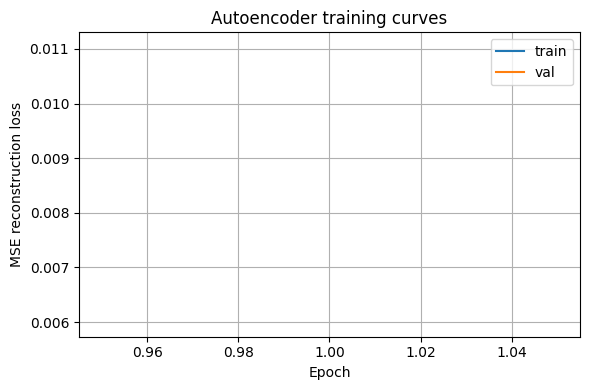

In [11]:
# %%
history_df = pd.DataFrame(history)
history_df.head()

plt.figure()
plt.plot(history_df["epoch"], history_df["train_loss"], label="train")
if not np.all(np.isnan(history_df["val_loss"].to_numpy())):
    plt.plot(history_df["epoch"], history_df["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE reconstruction loss")
plt.title("Autoencoder training curves")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Save model, config snapshot, and training history

In [12]:
# %%
logging_cfg = config.get("logging", {})
output_dir = logging_cfg.get("output_dir", "autoencoder_runs")
os.makedirs(output_dir, exist_ok=True)

data_cfg = config["data"]
folder = data_cfg["folder"]
folder_name = os.path.basename(os.path.abspath(folder)) or "root"

use_all_times = bool(data_cfg.get("use_all_times", True))
if use_all_times:
    tw_str = "all"
else:
    start_time = data_cfg.get("start_time", "00:00:00")
    end_time = data_cfg.get("end_time", "23:59:59")
    tw_str = f"{start_time.replace(':','')}-{end_time.replace(':','')}"

mode = "gray" if data_cfg.get("grayscale", True) else "rgb"
frame_step = int(data_cfg.get("frame_step", 1))

base_data_id = f"{folder_name}_w{img_w}h{img_h}_{mode}_tw{tw_str}_step{frame_step}"

config_base = os.path.splitext(os.path.basename(CONFIG_PATH))[0]
seed_value = config.get("seed", 0)

run_id = f"{base_data_id}_{config_base}_seed{seed_value}"

model_base_name = f"ae_{run_id}"
model_path = os.path.join(output_dir, model_base_name + ".pt")
history_path = os.path.join(output_dir, model_base_name + "_history.csv")
config_snapshot_path = os.path.join(output_dir, model_base_name + "_config.yaml")

# Save state dict with some metadata
torch.save(
    {
        "model_state_dict": ae_model.state_dict(),
        "config": config,
        "history": history,
        "data_folder": folder,
        "frame_step": frame_step,
        "time_window": {
            "use_all_times": use_all_times,
            "start_time": data_cfg.get("start_time", "00:00:00"),
            "end_time": data_cfg.get("end_time", "23:59:59"),
        },
    },
    model_path,
)
print("Saved model to:", model_path)

# Save training history
history_df.to_csv(history_path, index=False)
print("Saved training history to:", history_path)

# Save a copy of the used config with a name that matches the model
with open(config_snapshot_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(config, f)
print("Saved config snapshot to:", config_snapshot_path)


Saved model to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_example_seed0.pt
Saved training history to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_example_seed0_history.csv
Saved config snapshot to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_example_seed0_config.yaml


## 10. Reconstruction examples

Saved reconstruction grid to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_example_seed0_recon.png


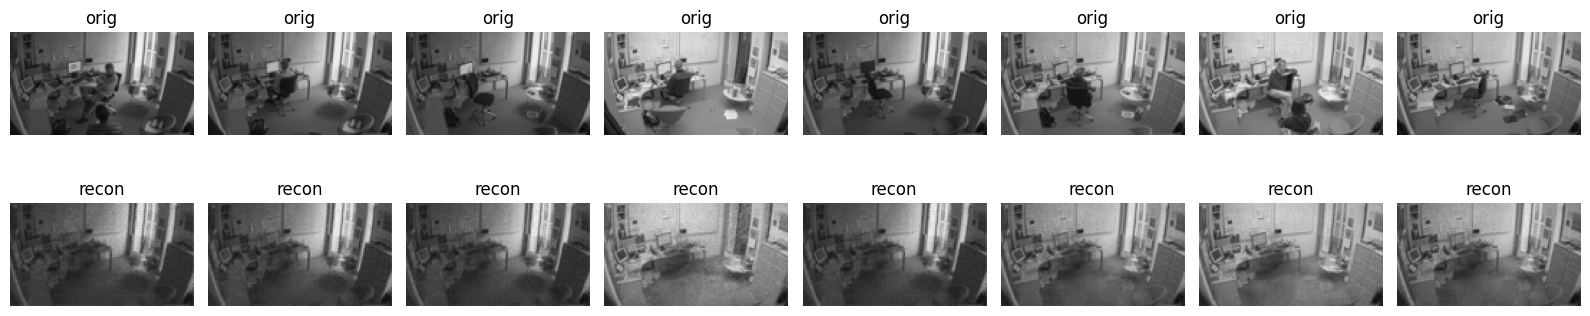

In [13]:
# %%
@torch.no_grad()
def plot_reconstructions(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device,
    num_examples: int = 8,
    out_path: Optional[str] = None,
):
    model.eval()
    # Fetch first batch
    batch = next(iter(loader))
    if line_col_present:
        imgs, _lines = batch
    else:
        imgs = batch

    imgs = imgs.to(device)
    recon, _ = model(imgs)

    imgs = imgs.cpu().numpy()
    recon = recon.cpu().numpy()

    n = min(num_examples, imgs.shape[0])

    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        orig = imgs[i]
        rec = recon[i]

        if in_channels == 1:
            orig_img = orig[0]
            rec_img = rec[0]
            cmap = "gray"
        else:
            orig_img = np.transpose(orig, (1, 2, 0))
            rec_img = np.transpose(rec, (1, 2, 0))
            cmap = None

        axes[0, i].imshow(orig_img, cmap=cmap, vmin=0.0, vmax=1.0)
        axes[0, i].axis("off")
        axes[0, i].set_title("orig")

        axes[1, i].imshow(rec_img, cmap=cmap, vmin=0.0, vmax=1.0)
        axes[1, i].axis("off")
        axes[1, i].set_title("recon")

    plt.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=300)
        print("Saved reconstruction grid to:", out_path)
    plt.show()


num_recon_examples = int(logging_cfg.get("num_recon_examples", 8))
recon_out_path = os.path.join(output_dir, model_base_name + "_recon.png")

loader_for_recon = val_loader if val_loader is not None else train_loader
plot_reconstructions(
    ae_model,
    loader_for_recon,
    device,
    num_examples=num_recon_examples,
    out_path=recon_out_path,
)


## 11. Latent space scatterplot (2D)

Latent shape: (236651, 2)
Saved latent scatterplot to: autoencoder_runs\ae_edinburgh-office-data_w128h72_gray_twall_step1_ae_cnn_example_seed0_latent_scatter.png


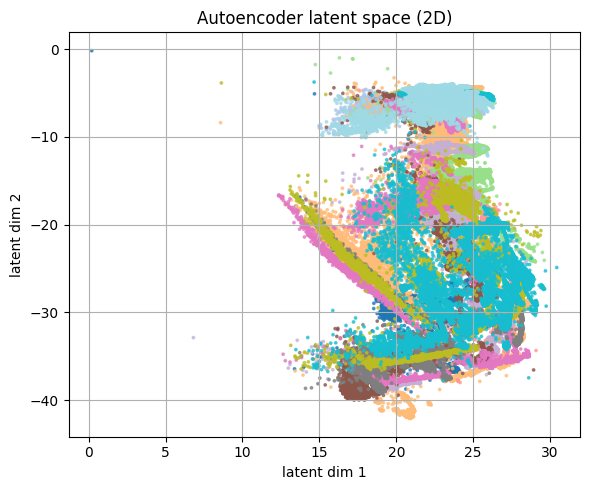

In [14]:
# %%
@torch.no_grad()
def compute_latent_and_lines(
    model: nn.Module,
    dataset: Dataset,
    device: torch.device,
    batch_size: int = 1024,
) -> Tuple[np.ndarray, Optional[np.ndarray]]:
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,   # 0 is fine – just indexing a tensor
        pin_memory=True,
    )

    model.eval()
    zs = []
    ls = [] if line_col_present else None

    for batch in loader:
        if line_col_present:
            imgs, batch_lines = batch
            ls.append(batch_lines.numpy())
        else:
            imgs = batch

        imgs = imgs.to(device, non_blocking=True)
        _, z = model(imgs)
        zs.append(z.cpu().numpy())

    Z = np.concatenate(zs, axis=0)
    if line_col_present and ls is not None:
        lines = np.concatenate(ls, axis=0)
    else:
        lines = None
    return Z, lines


Z, latent_lines = compute_latent_and_lines(
    ae_model, full_dataset, device, batch_size=1024
)
print("Latent shape:", Z.shape)

plt.figure(figsize=(6, 5))
if Z.shape[1] >= 2:
    x = Z[:, 0]
    y = Z[:, 1]
else:
    x = Z[:, 0]
    y = np.zeros_like(x)

if latent_lines is not None:
    # Color by day/line (same semantics as the first notebook's UMAP plots)
    cat = pd.Categorical(latent_lines)
    codes = cat.codes
    sc = plt.scatter(x, y, c=codes, s=3, alpha=0.7, cmap="tab20")
else:
    sc = plt.scatter(x, y, s=3, alpha=0.7)

plt.xlabel("latent dim 1")
plt.ylabel("latent dim 2" if Z.shape[1] >= 2 else "0")
plt.title("Autoencoder latent space (2D)")
plt.tight_layout()

latent_out_path = os.path.join(output_dir, model_base_name + "_latent_scatter.png")
plt.savefig(latent_out_path, dpi=300)
print("Saved latent scatterplot to:", latent_out_path)
plt.show()
